## Discretisation

Discretisation is the process of transforming continuous variables into discrete variables by creating a set of contiguous intervals that spans the range of the variable's values.

### Discretisation helps handle outliers and highly skewed variables

Discretisation helps handle outliers by placing these values into the lower or higher intervals together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.


### Discretisation approaches

There are several approaches to transform continuous variables into discrete ones. This process is also known as **binning**, with each bin being each  interval. Discretisation methods fall into 2 categories: **supervised and unsupervised**. Unsupervised methods do not use any information, other than the variable distribution, to create the contiguous bins in which the values will be placed. Supervised methods typically use target information in order to create the bins or intervals.

####  Unsupervised discretisation methods

- Equal width binning
- Equal frequency binning


#### Supervised discretisation methods

- Discretisation using decision trees


In this lecture, I will describe **equal width discretisation**.


## Equal width discretisation

Equal width binning divides the scope of possible values into N bins of the same width.The width is determined by the range of values in the variable and the number of bins we wish to use to divide the variable.

width = (max value - min value) / N

For example if the values of the variable vary between 0 and 100, we create 5 bins like this: width = (100-0) / 5 = 20. The bins thus are 0-20, 20-40, 40-60, 80-100. The first and final bins (0-20 and 80-100) can be expanded to accommodate outliers (that is, values under 0 or greater than 100 would be placed in those bins as well).

There is no rule of thumb to define N. Typically, we would not want more than 10.

I will demonstrate how to perform equal width binning using the Titanic dataset.

### Titanic dataset

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
# load the numerical variables of the Titanic Dataset

data = pd.read_csv('titanic.csv', usecols = ['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


#### Fill missing data with random sample

In [3]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data[['Age', 'Fare', 'Survived']], data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

The variable Age contains missing data, that I will fill by extracting a random sample of the variable.

In [4]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [5]:
# replace NA in both  train and test sets

X_train['Age'] = impute_na(data, 'Age')
X_test['Age'] = impute_na(data, 'Age')

### Age
### Original distribution

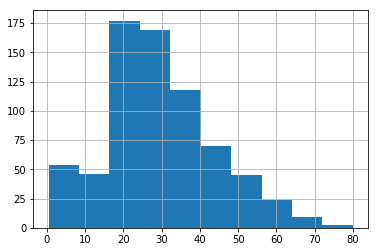

In [6]:
# let's remind ourselves of the distribution of Age
data.Age.hist()

**How does survival correlate with Age?**

We can determine the relation between survival and Age by plotting the mean survival per Age. In this case, I will calculate the Survival rate per each year of Age. See below.

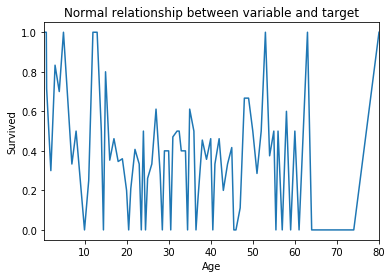

In [7]:
fig = plt.figure()
fig = data.groupby(['Age'])['Survived'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

By looking at the plot, we get an intuition that younger people (children) were more likely to survive (see higher survival rates at ages below 10 and 10-15). However, it looks like children of 10 years of age, had a very low survival chance. This does not make a lot of sense and most likely indicates that our 10 year old sample is not big enough and then the survival rate is underestimated. Let's see below.

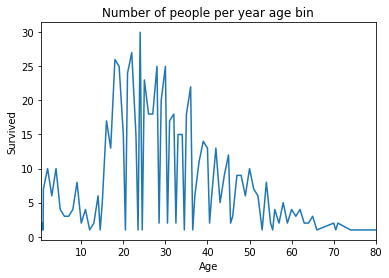

In [8]:
fig = plt.figure()
fig = data.groupby(['Age'])['Survived'].count().plot()
fig.set_title('Number of people per year age bin')
fig.set_ylabel('Survived')

As we suspected, there were very few children at the age of 10 on the Titanic. If none of them or only half of the 10 year old children survived, we would be led to think that being 10 years old decreased your chances of survival, when in reality, there were only 2 children of the age that were not lucky enough  to survive, therefore leading to underestimation of survival rate.

By grouping Age into bins, we can get a better view of the survival rate depending on the Age of the passenger. Let's see below.

### Discretisation with range

In [9]:
# let's capture the range of the variable age to begin with

Age_range = X_train.Age.max() - X_train.Age.min()
Age_range

79.329999999999998

In [10]:
# let's divide the range into 10 equal width bins

Age_range/10

7.9329999999999998

The range or width of our intervals will be 8 years.

In [11]:
# not let's capture the lower and upper boundaries

min_value = int(np.floor(X_train.Age.min()))
max_value = int(np.ceil(X_train.Age.max()))

# let's round the bin width
inter_value = int(np.round(Age_range/10))

min_value, max_value, inter_value

(0, 80, 8)

In [12]:
# let's capture the interval limits, so we can pass them to the pandas cut function to generate
# the bins

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
intervals

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80]

In [13]:
# let's make labels to label the different bins
labels = ['Bin_'+str(i) for i in range(1,len(intervals))]
labels

['Bin_1',
 'Bin_2',
 'Bin_3',
 'Bin_4',
 'Bin_5',
 'Bin_6',
 'Bin_7',
 'Bin_8',
 'Bin_9',
 'Bin_10']

In [14]:
# create binned age

# create one column with labels
X_train['Age_disc_labels'] = pd.cut(x = X_train.Age, bins=intervals, labels=labels, include_lowest=True)

# and one with bin boundaries
X_train['Age_disc'] = pd.cut(x = X_train.Age, bins=intervals, include_lowest=True)

X_train.head()

,Age,Fare,Survived,Age_disc_labels,Age_disc
857,51.0,26.5500,1,Bin_7,"(48.0, 56.0]"
52,49.0,76.7292,1,Bin_7,"(48.0, 56.0]"
386,1.0,46.9000,0,Bin_1,"(-0.001, 8.0]"
124,54.0,77.2875,0,Bin_7,"(48.0, 56.0]"
578,14.5,14.4583,0,Bin_2,"(8.0, 16.0]"


We can see in the above output how by discretising using equal width, we placed each Age observation within one interval /bin. For example, age 51 was placed in the 48-56 interval, whereas age 14.5 was placed into the 8-16 interval.

Because we discretised the variable using equal width intervals instead of equal frequency, there won't necessarily be the same amount of passengers in each of the intervals. See below.

In [15]:
X_train.groupby('Age_disc')['Age'].count()

Age_disc
(-0.001, 8.0]     49
(8.0, 16.0]       36
(16.0, 24.0]     147
(24.0, 32.0]     146
(32.0, 40.0]     112
(40.0, 48.0]      68
(48.0, 56.0]      37
(56.0, 64.0]      19
(64.0, 72.0]       7
(72.0, 80.0]       2
Name: Age, dtype: int64

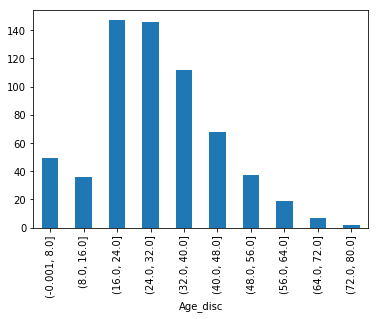

In [16]:
X_train.groupby('Age_disc')['Age'].count().plot.bar()

The majority of people on the Titanic were between 16-40 years of age.

Now, we can discretise Age in the test set, using the same interval boundaries that we calculated for the train set. See below.

In [17]:
X_test['Age_disc_labels'] = pd.cut(x = X_test.Age, bins=intervals, labels=labels, include_lowest=True)
X_test['Age_disc'] = pd.cut(x = X_test.Age, bins=intervals,  include_lowest=True)

X_test.head()

,Age,Fare,Survived,Age_disc_labels,Age_disc
495,42.0,14.4583,0,Bin_6,"(40.0, 48.0]"
648,18.0,7.5500,0,Bin_3,"(16.0, 24.0]"
278,7.0,29.1250,0,Bin_1,"(-0.001, 8.0]"
31,35.0,146.5208,1,Bin_5,"(32.0, 40.0]"
255,29.0,15.2458,1,Bin_4,"(24.0, 32.0]"


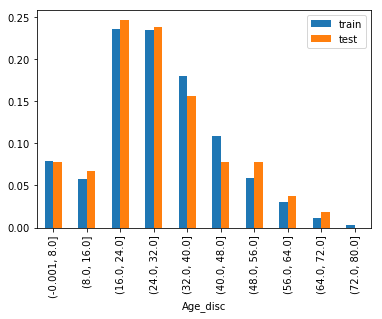

In [18]:
# if the distributions in train and test set are similar, we should expect similar distribution of 
# observations in the different intervals in the train and test set
# let's see that below

t1 = X_train.groupby(['Age_disc'])['Survived'].count() / np.float(len(X_train))
t2 = X_test.groupby(['Age_disc'])['Survived'].count() / np.float(len(X_test))
temp = pd.concat([t1,t2], axis=1)
temp.columns = ['train', 'test']
temp.plot.bar()


Indeed, the proportion of passengers within each bin is roughly the same.

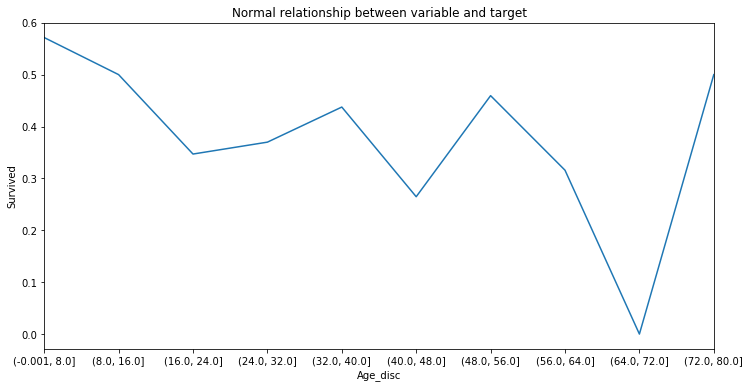

In [19]:
# and now let's observe the relationship between age and surival again, using the discrete Age transformed 
# variable

fig = plt.figure()
fig = X_train.groupby(['Age_disc'])['Survived'].mean().plot(figsize=(12,6))
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('Survived')

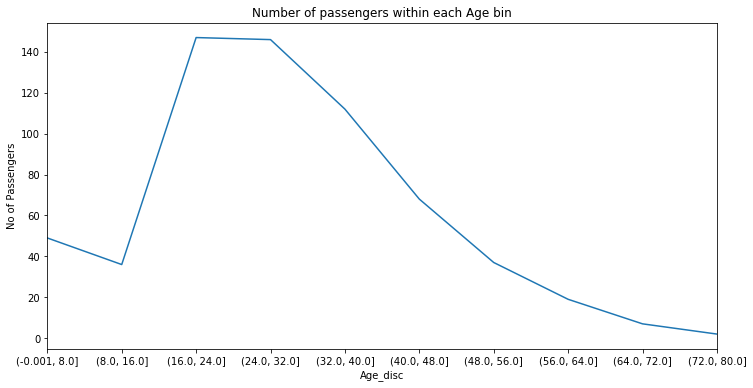

In [20]:
fig = plt.figure()
fig = X_train.groupby(['Age_disc'])['Survived'].count().plot(figsize=(12,6))
fig.set_title('Number of passengers within each Age bin')
fig.set_ylabel('No of Passengers')

In this case, by dividing Age into bins, we removed some of the noise plotted in the previous graph (a few cells ago) using the untransformed Age. Using the discrete variable Age, we observe as expected that children (<16) had the highest survival chance.

What happens to older people is less clear from the discrete variable. It looks like people between 32-40 and 48-56 are more likely to survive, than people from 40-48. This might or might not be true and more research would be needed to determine if this was the case, what the reason behind it was. In addition, it looks like being extremely old, was very favourable for survival (look at the 72-80 bucket). However, most likely, these are consequences of an arbitrary binning strategy. There are very few people in the bucket 72-80, and thus, the fact that 1 of them survived inflates (overestimates) the survival rate for that bucket. And the same is true for the remaining of the bins, the lowest the amount of observations within buckets, the highest the risk of over or underestimating the target (survival in this case). So we begin to see some of the consequences of this binning strategy.

Similarly to what we did with the equal frequency discretised Age variable in the previous lecture, here as well to squeeze a bit more performance out of the machine learning algorithm, we can add a layer of transformation by sorting the bins using the survival rate (the caveat being that the survival rate may be over or underestimated as we explained in the previous paragraph). But just for a demonstration, let's go ahead. See below.

### Combine discretisation with label ordering according to target

You can revise the lectures on engineering categorical variables to re-cap on how to preprocess labels.

For this demonstration I will assign ordinal numbers to the different bins, according to the survival rate per bin.

In [21]:
# order the bins according to survival rate
ordered_labels = X_train.groupby(['Age_disc_labels'])['Survived'].mean().sort_values().index
ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)}

# transformed the discrete age variable
X_train['Age_disc_ordered'] = X_train.Age_disc_labels.map(ordinal_label)
X_test['Age_disc_ordered'] = X_test.Age_disc_labels.map(ordinal_label)

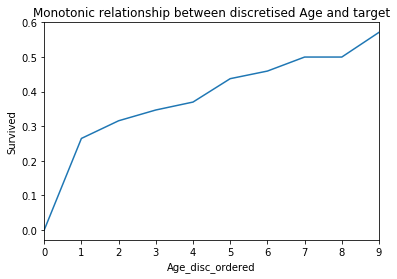

In [22]:
fig = plt.figure()
fig = X_train.groupby(['Age_disc_ordered'])['Survived'].mean().plot()
fig.set_title('Monotonic relationship between discretised Age and target')
fig.set_ylabel('Survived')

### Fare

Let's look at the consequences of equal width discretisation on highly skewed variables like Fare.

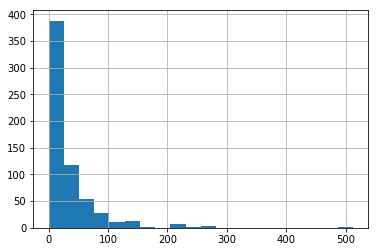

In [23]:
# let's plot the hist, to remind us of the skewness of Fare

X_train.Fare.hist(bins=20)

In [24]:
Fare_range = X_train.Fare.max() - X_train.Fare.min()
Fare_range

512.32920000000001

In [25]:
min_value = int(np.floor(X_train.Fare.min()))
max_value = int(np.ceil(X_train.Fare.max()))
inter_value = int(np.round(Fare_range/10))

intervals = [i for i in range(min_value, max_value+inter_value, inter_value)]
intervals

[0, 51, 102, 153, 204, 255, 306, 357, 408, 459, 510, 561]

In [26]:
len(intervals)

12

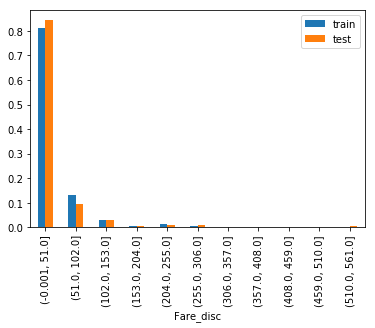

In [27]:
X_train['Fare_disc'] = pd.cut(x = X_train.Fare, bins=intervals, include_lowest=True)
X_test['Fare_disc'] = pd.cut(x = X_test.Fare, bins=intervals, include_lowest=True)

# if the distributions in train and test set are similar, we should expect similar distribution of 
# observations in the different intervals in the train and test set
t1 = X_train.groupby(['Fare_disc'])['Survived'].count() / np.float(len(X_train))
t2 = X_test.groupby(['Fare_disc'])['Survived'].count() / np.float(len(X_test))
temp = pd.concat([t1,t2], axis=1)
temp.columns = ['train', 'test']
temp.plot.bar()

For very skewed variables, discretisation using range is not a good option, as it ends up putting the majority of the observations within 1 or 2 buckets, and the remaining are almost empty or empty.

For very skewed variables, quantile discretisation may be a better choice.

**That is all for this demonstration. I hope you enjoyed the notebook, and see you in the next one.**